# Figure 4 line plot in manuscript 

> Clean version of `compare-sw.ipynb` 

In [ ]:
era1022 = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/surf_ds_2010_22.zarr'))

In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import json
import gcsfs
from scipy.signal import detrend
from scipy import stats
from scipy.stats import linregress
import cmocean

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [ ]:
#era1022 = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/surf_ds_2010_22.zarr'))
era23 = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/gom_updated.zarr'))
era1023 = xr.merge([era1022, era23])
era1023_sliced = era1023.sel(longitude=slice(-100,-80))

era24_rest = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/2024-rest_up2june.zarr'))
era24_r = era24_rest.sel(longitude=slice(-100,-80))
era24_sst = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/2024-sst_up2june.zarr'))
era24_ssr = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/2024-ssr_up2june.zarr'))
era_fluxes2024 = xr.merge([era24_r, era24_ssr, era24_sst])

era = xr.merge([era1023_sliced, era_fluxes2024])

/srv/conda/envs/notebook/lib/python3.11/site-packages/xarray/core/indexing.py:1617: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.11/site-packages/xarray/core/indexing.py:1617: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/srv/conda/envs/no

In [ ]:
era

In [3]:
## convert from J/m^2 -> W/m^2
era_wm2 = era.drop_vars('sst') / (60*60)
#resample to daily freq (hourly too noisy
era_daily = era_wm2.resample(time='D').mean('time')

#change from kelvin to celsius and resample to daily freq
era_sst = (era.sst-273.15).resample(time='D').mean('time')

In [4]:
sst = era_sst.load()

In [5]:
surfs = era_daily.load()

In [6]:
surfs

<xarray.Dataset> Size: 58MB
Dimensions:    (time: 547, latitude: 41, longitude: 81)
Coordinates:
  * latitude   (latitude) float32 164B 31.0 30.75 30.5 30.25 ... 21.5 21.25 21.0
  * longitude  (longitude) float32 324B -100.0 -99.75 -99.5 ... -80.25 -80.0
  * time       (time) datetime64[ns] 4kB 2023-01-01 2023-01-02 ... 2024-06-30
Data variables:
    slhf       (time, latitude, longitude) float64 15MB -36.64 -40.95 ... -144.7
    sshf       (time, latitude, longitude) float64 15MB 25.6 28.48 ... -5.405
    ssr        (time, latitude, longitude) float64 15MB 121.3 121.6 ... 293.3
    str        (time, latitude, longitude) float64 15MB -90.32 -89.86 ... -52.82
Attributes:
    Conventions:  CF-1.6
    history:      2024-04-29 19:17:30 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

## Take monthly climatology

In [7]:
mo_clim_e_sst = sst.groupby('time.month').mean(['time', 'latitude', 'longitude'])
emonthly_sst = sst.resample(time='ME').mean().mean(['latitude', 'longitude'])

mo_clim_e_surfs = surfs.groupby('time.month').mean(['time', 'latitude', 'longitude'])
emonthly_surfs = surfs.resample(time='ME').mean().mean(['latitude', 'longitude'])

mo_clim_sans_ssr = mo_clim_e_surfs.drop_vars('ssr')
emonthly_sans_ssr = emonthly_surfs.drop_vars('ssr')

In [8]:
mo_clim_e_sst

<xarray.DataArray 'sst' (month: 12)> Size: 96B
array([23.37503862, 23.05510123, 24.09013334, 25.00419603, 27.20284845,
       29.04964405, 30.34686098, 30.86567541, 30.41412671, 28.60980692,
       26.32200225, 24.39686312])
Coordinates:
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12

In [9]:
emonthly_sst

<xarray.DataArray 'sst' (time: 18)> Size: 144B
array([23.73645184, 23.4834764 , 24.33848373, 25.34409156, 26.98251896,
       28.88106732, 30.34686098, 30.86567541, 30.41412671, 28.60980692,
       26.32200225, 24.39686312, 23.0136254 , 22.64149763, 23.84178295,
       24.6643005 , 27.42317793, 29.21822079])
Coordinates:
  * time     (time) datetime64[ns] 144B 2023-01-31 2023-02-28 ... 2024-06-30

In [15]:
emonthly_surfs.ssr.sel(time='2024')

<xarray.DataArray 'ssr' (time: 6)> Size: 48B
array([128.29534638, 170.86056241, 204.70417563, 250.37696176,
       265.26553258, 246.68705647])
Coordinates:
  * time     (time) datetime64[ns] 48B 2024-01-31 2024-02-29 ... 2024-06-30

In [16]:
mo_clim_sans_ssr.to_array().sum('variable')

<xarray.DataArray (month: 12)> Size: 96B
array([-211.59774889, -207.49570962, -186.30246818, -196.05156615,
       -169.95428688, -191.34234198, -196.09532385, -207.73699154,
       -203.07079307, -252.37151572, -238.09748841, -240.58212656])
Coordinates:
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12

In [17]:
#expand 2024 so you can plot it below
import pandas as pd

date_range = ['2024-01-31T00:00:00.000000000', '2024-02-29T00:00:00.000000000',
       '2024-03-31T00:00:00.000000000', '2024-04-30T00:00:00.000000000',
       '2024-05-31T00:00:00.000000000', '2024-06-30T00:00:00.000000000',
       '2024-07-31T00:00:00.000000000', '2024-08-31T00:00:00.000000000',
       '2024-09-30T00:00:00.000000000', '2024-10-31T00:00:00.000000000',
       '2024-11-30T00:00:00.000000000', '2024-12-31T00:00:00.000000000']
months2024 = pd.to_datetime(date_range)

#first 5 values come from latest May data 
array_sst = [23.0136254 , 22.64149763, 23.84178295, 24.6643005 , 27.42317793, 29.21822079,
             np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
array_ssr = [128.29534638, 170.86056241, 204.70417563, 250.37696176, 265.26553258, 246.68705647,
             np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
array_rest = [-217.91141335, -220.53086316, -175.58999006, -202.37474844, -158.31113041, -194.04170371,
              np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]

array_sst2024 = xr.DataArray(data=array_sst, coords={'time':months2024})
array_ssr2024 = xr.DataArray(data=array_ssr, coords={'time':months2024})
array_rest2024 = xr.DataArray(data=array_rest, coords={'time':months2024})

#insert to emonthly
emonthly_filled_sst = xr.concat([emonthly_sst.sel(time=slice(None, '2023')), array_sst2024], dim='time')
emonthly_filled_ssr = xr.concat([emonthly_surfs.ssr.sel(time=slice(None, '2023')), array_ssr2024], dim='time')
emonthly_filled_rest = xr.concat([emonthly_sans_ssr.sel(time=slice(None, '2023')).to_array().sum('variable'), 
                                  array_rest2024], dim='time')

In [18]:
emonthly_filled_sst

<xarray.DataArray 'sst' (time: 24)> Size: 192B
array([23.73645184, 23.4834764 , 24.33848373, 25.34409156, 26.98251896,
       28.88106732, 30.34686098, 30.86567541, 30.41412671, 28.60980692,
       26.32200225, 24.39686312, 23.0136254 , 22.64149763, 23.84178295,
       24.6643005 , 27.42317793, 29.21822079,         nan,         nan,
               nan,         nan,         nan,         nan])
Coordinates:
  * time     (time) datetime64[ns] 192B 2023-01-31 2023-02-28 ... 2024-12-31

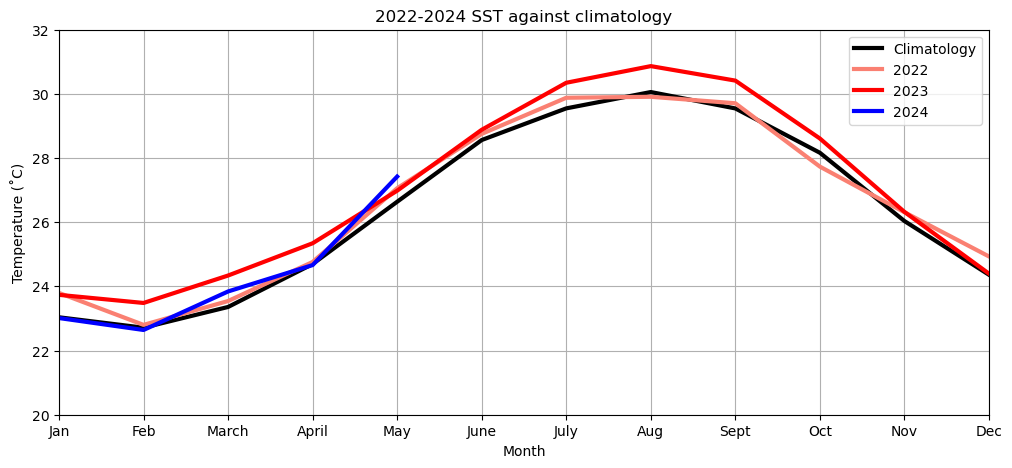

In [21]:
months = ['Jan', 'Feb', 'March', 'April', 'May', 'June', 
          'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', ]
plt.figure(figsize=(12,5))
plt.plot(months, mo_clim_e_sst, label='Climatology', color='k', linewidth=3)
plt.plot(months, emonthly_filled_sst.sel(time=slice('2022', '2022')), label='2022', linewidth=3, color='salmon')
plt.plot(months, emonthly_filled_sst.sel(time=slice('2023', '2023')), label='2023', linewidth=3, color='red')
plt.plot(months, emonthly_filled_sst.sel(time=slice('2024', '2024')), label='2024', linewidth=3, color='blue')
plt.xlim('Jan', 'Dec')
plt.ylim(20,32)
plt.grid()
plt.legend()
plt.ylabel('Temperature (˚C)')
plt.xlabel('Month')
plt.title('2022-2024 SST against climatology');
plt.savefig('paper-figs/era/sst-clim-line-plot.pdf')